# Creating a custom data integration model

**transmorph** provides several pre-built data integration models, but some scenarios require to create custom data integration models from scratch using the model API. This tutorial presents the basics of model building for data integration using **transmorph**.

## Model architecture

A **transmorph** model is a network of successive *layers*, which can be endowed with *algorithms*. As an example, let us take a look at one of the pre-built models, *EmbedMNN* using the *plot_model* function.

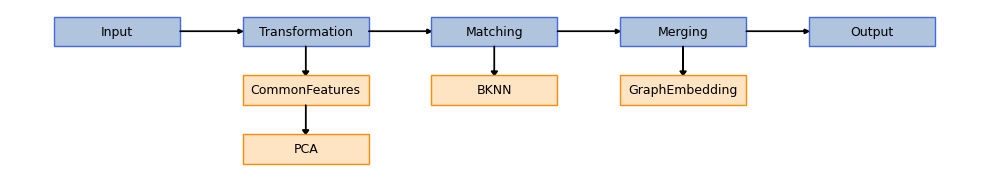

In [1]:
from transmorph.models import EmbedMNN
from transmorph.utils.plotting import plot_model

embedmnn_model = EmbedMNN()
plot_model(embedmnn_model)

In this representaion, blue blocks represent layers and orange ones represent algorithms. As we can see, EmbedMNN is composed of:
- An input layer, which is the first layer AnnData objects are sent to
- A transformation layer, which carries out some preprocessing steps
- A matching layer, which leverages batch k-nearest neighbors (BKNN) algorithm to match cells across datasets
- A merging (or embedding) layer, which interprets BKNN correspondences as the edges of a graph which is subsequently embedded in a low dimensional space
- An output layer, which writes the latest computed representation to the AnnData objects

## Recreating the EmbedMNN model using the model API

We will not showcase how to use **transmorph** model API to create a model similar to EmbedMNN. Let us first import the different blocks we need, contained in *transmorph.engine*.

In [9]:
from transmorph.engine import Model
from transmorph.engine.layers import *  # We import all layers for simplicity
from transmorph.engine.transforming import CommonFeatures, PCA
from transmorph.engine.matching import BKNN
from transmorph.engine.merging import GraphEmbedding

Then, we must define the different layers that our model consists of. We start with the input layers, which does not need extra information.

In [8]:
# 0: Input
layer_input = LayerInput()

Then, we prepare the transformation layer and endow it with the two preprocessing algorithms. **These algorithms will be carried out following their order of addition.** We will first select common genes across datasets, then conduct principal component analysis using 30 components, with all datasets together. As we can see, **transmorph** uses an object-oriented approach where each algorithmic module is an object, and algorithm parameters can be passed to the object constructor.

In [7]:
# 1: Transformation
layer_transformation = LayerTransformation()
layer_transformation.add_transformation(CommonFeatures())
layer_transformation.add_transformation(PCA(n_components=30))

Matching and merging layers just needs the matching or merging scheme they must use. Finally, every model must end with an output layer. 

In [6]:
# 2: Matching
layer_matching = LayerMatching(matching=BKNN())

# 3: Merging
layer_merging = LayerMerging(merging=GraphEmbedding())

# 4: Output
layer_output = LayerOutput()

Now, we can specify connections between layers and wrap up our model.

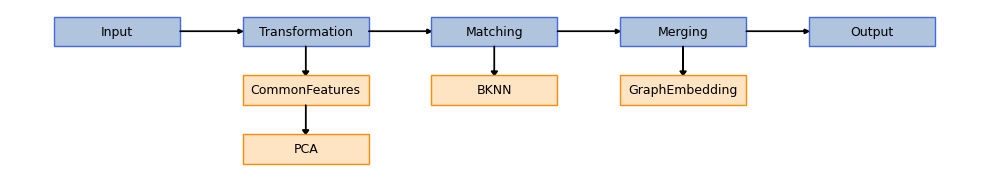

In [14]:
# Setting up the forward connections
layer_input.connect(layer_transformation)
layer_transformation.connect(layer_matching)
layer_matching.connect(layer_merging)
layer_merging.connect(layer_output)

# Model instantiation
my_model = Model(input_layer=layer_input)

plot_model(my_model)

## Testing this model on a single-cell dataset

We can now use the model we just built to carry out integration of single-cell data. As usual, its input type is a dictionary of AnnData objects. We use here the [Pal 2021] databank which can be downloaded via our databank API.

[Pal 2021] *Pal, B., Chen, Y., Vaillant, F., Capaldo, B. D., Joyce,
           R., Song, X., ... & Visvader, J. E. (2021). A single‐cell
           RNA expression atlas of normal, preneoplastic and tumorigenic
           states in the human breast. The EMBO journal, 40(11), e107333.*

In [15]:
from transmorph.datasets import load_pal_10x

datasets = load_pal_10x()
datasets

databank_api > Loading bank pal_10x.
databank_api > Bank pal_10x successfully loaded.


{'patient_1': AnnData object with n_obs × n_vars = 20027 × 10000
     obs: 'class_type', 'class_iscancer',
 'patient_2': AnnData object with n_obs × n_vars = 3782 × 10000
     obs: 'class_type', 'class_iscancer',
 'patient_3': AnnData object with n_obs × n_vars = 10824 × 10000
     obs: 'class_type', 'class_iscancer',
 'patient_4': AnnData object with n_obs × n_vars = 21760 × 10000
     obs: 'class_type', 'class_iscancer',
 'patient_5': AnnData object with n_obs × n_vars = 36774 × 10000
     obs: 'class_type', 'class_iscancer'}

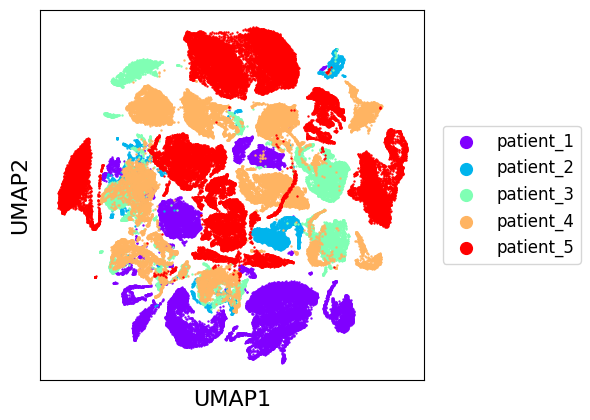

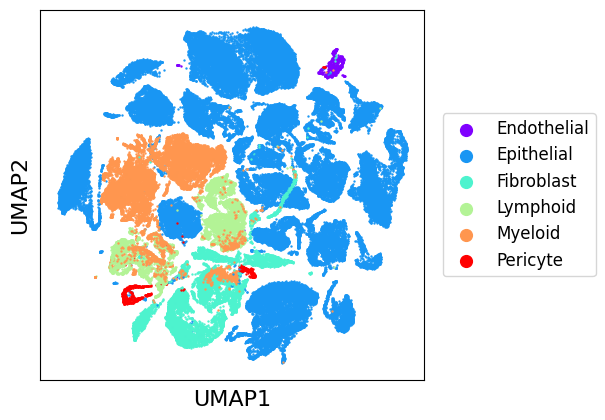

In [23]:
from transmorph.utils.plotting import reduce_dimension, scatter_plot

reduce_dimension(datasets, reducer="umap", output_obsm="raw_umap")

scatter_plot(datasets, use_rep="raw_umap")
scatter_plot(datasets, use_rep="raw_umap", color_by="class_type")

In [17]:
%%time
my_model.fit(datasets, output_representation="X_my_model")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 5 datasets, 93167 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#12.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#11.
CUSTOM_MODEL > Running layer LAYER_MATCHING#8.
LAYER_MATCHING#8 > Calling matching MATCHING_MNN.
CUSTOM_MODEL > Running layer LAYER_MERGING#9.
LAYER_MERGING#9 > Running merging MERGING_GRAPH_EMBEDDING...
CUSTOM_MODEL > Running layer LAYER_OUTPUT#10.
CUSTOM_MODEL > Terminated. Total embedding shape: (93167, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['transmorph'].
CPU times: total: 17min 15s
Wall time: 4min 27s


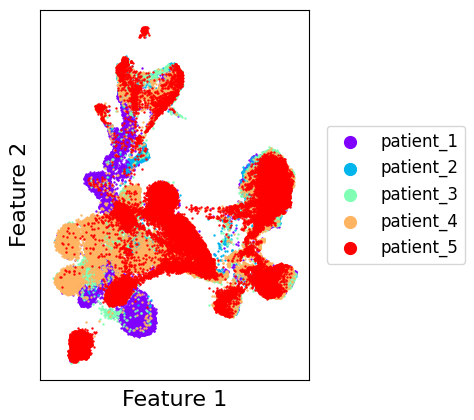

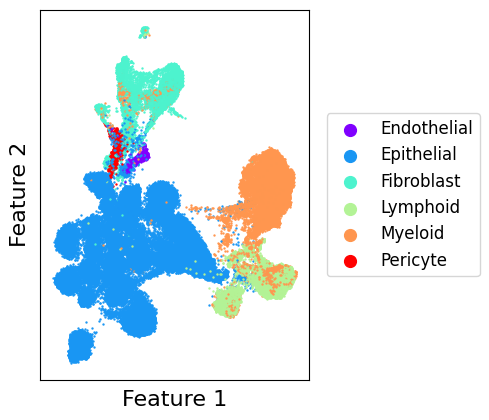

In [24]:
scatter_plot(datasets, use_rep="transmorph")
scatter_plot(datasets, use_rep="transmorph", color_by="class_type")

As we can see, out model did a good job at integrating datasets together while preserving cell type clustering. In the next tutorial, we will present in more details the different algorithmic modules that can be used to build models and provide a reasoning on their use cases.